# SET UP

### IMPORT LIBRARIES

In [1]:
import argparse
import ast
import csv
import itertools
import json
import os
import re

import cv2
import geopandas as gpd
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import scipy.linalg as la
from netgraph import InteractiveGraph, Graph
from numpy.linalg import eig
from PIL import Image
from shapely.geometry import Polygon, MultiPolygon
from tqdm import tqdm

import quantecon as qe

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx

### DEFINE GLOBAL VARIABLE

In [8]:
def getboundaryofamperfromregion(data):
    amperboundaries = {}
    for i in data.index:
        geom = data.at[i, "geometry"]
        pv_name = data.at[i, 'pv_tn']
        re_name = data.at[i, "re_royin"]
        ap_name = data.at[i, 'ap_tn'] if 'ap_tn' in data else ""

        if geom.geom_type == 'Polygon':
            # print("This geometry is a Polygon")
            coordinates_list = list(geom.exterior.coords)
            coordinates_list = [list(coordinate) for coordinate in coordinates_list]

        elif geom.geom_type == 'MultiPolygon':
            polygon_list = list(geom.geoms)  
            coordinates_list = []
            for polygon in polygon_list:
                polygon_coordinates_list = list(polygon.exterior.coords)
                coordinates_list += [list(coordinate) for coordinate in polygon_coordinates_list]

        amperkey = (ap_name, pv_name)
        centroid = geom.centroid
        amperboundaries[amperkey] = {'cor': coordinates_list, 'centroid':centroid}

    return amperboundaries

with open('data_gen/allprovincesTH.txt', 'r', encoding='utf-8') as file:
    allprovinces = []
    for line in file:
        allprovinces.append(line.strip())

central = gpd.read_file('data_base/boundary/query-2.geojson')
east = gpd.read_file('data_base/boundary/query-3.geojson')
north = gpd.read_file('data_base/boundary/query-4.geojson')
south = gpd.read_file('data_base/boundary/query-5.geojson')
northeast = gpd.read_file('data_base/boundary/query-6.geojson')
west = gpd.read_file('data_base/boundary/query-7.geojson')

geojsonlists = [central, east, north, south, northeast, west]

central_amperboundaries = getboundaryofamperfromregion(central)
east_amperboundaries = getboundaryofamperfromregion(east)
north_amperboundaries = getboundaryofamperfromregion(north)
south_amperboundaries = getboundaryofamperfromregion(south)
northeast_amperboundaries = getboundaryofamperfromregion(northeast)
west_amperboundaries = getboundaryofamperfromregion(west)

all_amperboundaries = {**central_amperboundaries, **east_amperboundaries, **north_amperboundaries, **south_amperboundaries, **northeast_amperboundaries, **west_amperboundaries}
allampers = list(all_amperboundaries.keys())

DICT_amper2int = {item: index for index, item in enumerate(allampers)}



In [38]:
all_amperboundaries[('พระนคร', 'กรุงเทพมหานคร')]['centroid'].xy[0][0]
all_amperboundaries[('พระนคร', 'กรุงเทพมหานคร')]['centroid'].xy[1][0]

13.755425619069753

In [ ]:
positions = dict()
for amper_tuple in allampers: 
    lat = all_amperboundaries[amper_tuple]['centroid'].xy[0][0]
    lon = all_amperboundaries[amper_tuple]['centroid'].xy[1][0]    
    positions[DICT_amper2int[amper_tuple]]  = (lat, lon)

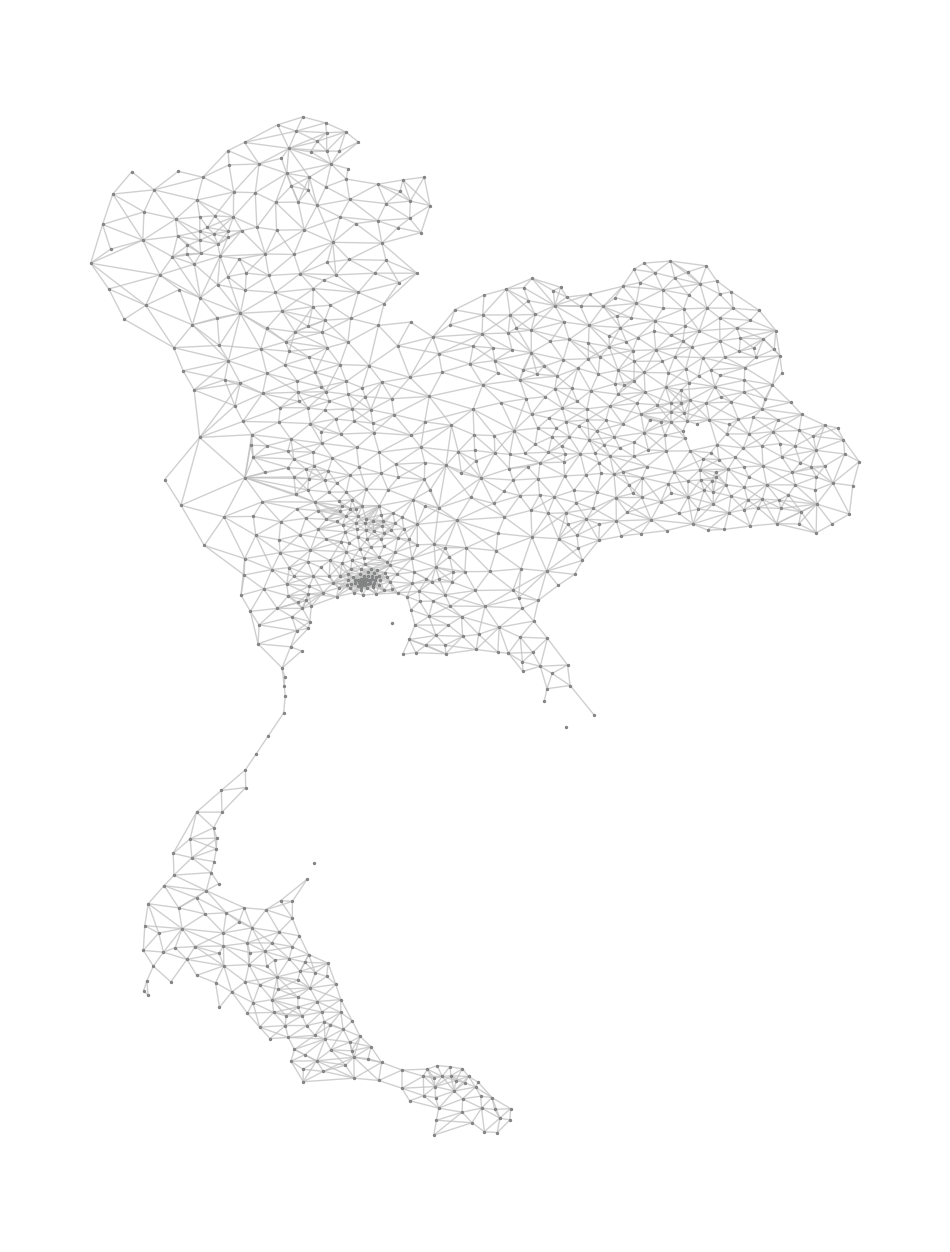

In [45]:
### DISTRICT BOUNDARY ###
csvfiles_path = "data_gen_adjacency_districts/"
csvfiles = os.listdir(csvfiles_path)

# csvfiles = csvfiles[0:2]

A = np.zeros([len(allampers),len(allampers)])

for csvfile in csvfiles:
    csvfile_path = csvfiles_path+csvfile
    df = pd.read_csv(csvfile_path)
    N = len(df)
    for i in range(N):
        amper1_tuple = ast.literal_eval(df.iloc[i]["Amper1"])
        amper2_tuple = ast.literal_eval(df.iloc[i]["Amper2"])

        amper1_index = DICT_amper2int[amper1_tuple]
        amper2_index = DICT_amper2int[amper2_tuple]

        
        A[amper1_index, amper2_index] = 1

G = nx.from_numpy_array(A)

nx.draw_networkx_nodes(G, positions, node_color='lightblue', node_size=2, edgecolors='gray', linewidths=1)
nx.draw_networkx_edges(G, positions, alpha=0.75, edge_color='silver', width =1)
# nx.draw_networkx_labels(G, positions, labels=labels, font_size=8, font_family='sans-serif')

# nx.draw(G, with_labels=True, node_color='lightblue', edge_color='blue', node_size=800, font_size=15)
# plt.show()

plt.axis('off')  # Removes the axis for a cleaner look
plt.gcf().set_size_inches(12, 16)  # Adjust the figure size if necessary for better visibility
 
plt.show()

In [46]:
G = nx.from_numpy_array(A) 

df = pd.DataFrame({
    'index': [DICT_amper2int[amper]+1 for amper in allampers], 
    'district': allampers
}) 

centralities = nx.degree_centrality(G)
centrality_list = [value for value in centralities.values()]

df['degree'] = centrality_list

df.to_csv("usecases/centrality_degree.csv", encoding='utf-8-sig')

In [47]:
G = nx.from_numpy_array(A) 

df = pd.DataFrame({
    'index': [DICT_amper2int[amper]+1 for amper in allampers], 
    'district': allampers
}) 

centralities = nx.eigenvector_centrality(G, weight='weight', max_iter=10000)
centrality_list = [value for value in centralities.values()]

df['degree'] = centrality_list

df.to_csv("usecases/eigenvector_centrality.csv", encoding='utf-8-sig')

In [50]:
eig, V = np.linalg.eig(A) 
max_eig=max(eig)
alpha0 = 1/(max_eig) 

alphas=np.linspace(0, alpha0, 100)

G = nx.from_numpy_array(A) 

df = pd.DataFrame({
    'index': [DICT_amper2int[amper]+1 for amper in allampers], 
    'district': allampers
}) 
alpha = alphas[1]

centralities =  nx.katz_centrality(G, weight= 'weight', alpha = alpha, max_iter = 100000)
centrality_list = [value for value in centralities.values()]

df['degree'] = centrality_list

df.to_csv("usecases/katz_centrality_numpy.csv", encoding='utf-8-sig')

In [ ]:
communities_generator = nx.community.girvan_newman(G)
top_level_communities = next(communities_generator)
next_level_communities = next(communities_generator)

sorted(map(sorted, next_level_communities))

In [54]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt

# Load karate graph and find communities using Girvan-Newman
# G = nx.karate_club_graph()
communities = list(nx.community.girvan_newman(G))

# Modularity -> measures the strength of division of a network into modules
modularity_df = pd.DataFrame(
    [
        [k + 1, nx.community.modularity(G, communities[k])]
        for k in range(len(communities))
    ],
    columns=["k", "modularity"],
)


def create_community_node_colors(graph, communities):
    number_of_colors = len(communities[0])
    colors = ["#D4FCB1", "#CDC5FC", "#FFC2C4", "#F2D140", "#BCC6C8"][:number_of_colors]
    node_colors = []
    for node in graph:
        current_community_index = 0
        for community in communities:
            if node in community:
                node_colors.append(colors[current_community_index])
                break
            current_community_index += 1
    return node_colors


def visualize_communities(graph, communities, i):
    node_colors = create_community_node_colors(graph, communities)
    modularity = round(nx.community.modularity(graph, communities), 6)
    title = f"Community Visualization of {len(communities)} communities with modularity of {modularity}"
    pos = nx.spring_layout(graph, k=0.3, iterations=50, seed=2)
    plt.subplot(3, 1, i)
    plt.title(title)
    nx.draw(
        graph,
        pos=positions,
        node_size=1000,
        node_color=node_colors,
        with_labels=True,
        font_size=20,
        font_color="black",
    )

fig, ax = plt.subplots(3, figsize=(15, 20))

# Plot graph with colouring based on communities
visualize_communities(G, communities[0], 1)
visualize_communities(G, communities[3], 2)

# Plot change in modularity as the important edges are removed
modularity_df.plot.bar(
    x="k",
    ax=ax[2],
    color="#F2D140",
    title="Modularity Trend for Girvan-Newman Community Detection",
)
plt.show()